# Spotify Genre Classifier

## Setup

In [46]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import walk, path

In [47]:
# load data

# get all filenames from the directory data
f = []
for (dirpath, dirnames, filenames) in walk("data"):
    f.extend(filenames)
    break

# load data from all files from the directory data
frames = []
for file in f:
    data = pd.read_json(path.join("data", file))
    frames.append(data)

# concat all data into one dataframe
raw_data = pd.concat(frames, ignore_index=True)

## Visualization

### Clean Dataset

In [48]:
raw_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0.1930,0.11600,9,-25.718,1,0.0608,0.986,0.91800,0.5050,0.0836,143.301,audio_features,6pV1dGidc6DvzjKhbMqgDa,spotify:track:6pV1dGidc6DvzjKhbMqgDa,https://api.spotify.com/v1/tracks/6pV1dGidc6Dv...,https://api.spotify.com/v1/audio-analysis/6pV1...,242467,3,classic
1,0.3210,0.00611,4,-38.341,0,0.0362,0.995,0.90800,0.0900,0.0693,104.311,audio_features,1YcABWwgkfrOSw8VMgDWZU,spotify:track:1YcABWwgkfrOSw8VMgDWZU,https://api.spotify.com/v1/tracks/1YcABWwgkfrO...,https://api.spotify.com/v1/audio-analysis/1YcA...,205493,4,classic
2,0.4480,0.00520,4,-36.512,1,0.0564,0.995,0.88000,0.0698,0.0398,62.171,audio_features,1juisCcrVdwoLbDWyVvNrX,spotify:track:1juisCcrVdwoLbDWyVvNrX,https://api.spotify.com/v1/tracks/1juisCcrVdwo...,https://api.spotify.com/v1/audio-analysis/1jui...,369027,4,classic
3,0.4250,0.03630,1,-21.629,0,0.0686,0.991,0.00109,0.2500,0.7450,78.991,audio_features,1AKdBq4wtJKU9DhQpekvtc,spotify:track:1AKdBq4wtJKU9DhQpekvtc,https://api.spotify.com/v1/tracks/1AKdBq4wtJKU...,https://api.spotify.com/v1/audio-analysis/1AKd...,143777,4,classic
4,0.0748,0.04420,0,-19.183,1,0.0426,0.957,0.94000,0.1160,0.0369,79.092,audio_features,5X5x6oRSCHtHEz28ncMVd5,spotify:track:5X5x6oRSCHtHEz28ncMVd5,https://api.spotify.com/v1/tracks/5X5x6oRSCHtH...,https://api.spotify.com/v1/audio-analysis/5X5x...,348907,4,classic


In [49]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre'],
      dtype='object')

In [72]:
# now drop some features which have no importance for the ML task
data = raw_data.drop(["uri", "id", "track_href", "analysis_url", "type"], axis=1)

In [51]:
data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'genre'],
      dtype='object')

In [52]:
data.shape

(1190, 14)

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1190 non-null   float64
 1   energy            1190 non-null   float64
 2   key               1190 non-null   int64  
 3   loudness          1190 non-null   float64
 4   mode              1190 non-null   int64  
 5   speechiness       1190 non-null   float64
 6   acousticness      1190 non-null   float64
 7   instrumentalness  1190 non-null   float64
 8   liveness          1190 non-null   float64
 9   valence           1190 non-null   float64
 10  tempo             1190 non-null   float64
 11  duration_ms       1190 non-null   int64  
 12  time_signature    1190 non-null   int64  
 13  genre             1190 non-null   object 
dtypes: float64(9), int64(4), object(1)
memory usage: 130.3+ KB


In [80]:
data.duration_ms /= 1000
data.rename(columns={"duration_ms": "duration_s"}, inplace=True)

In [73]:
# remove samples with key == -1
print(f"Removed samples: {len(data[data.key == -1])}")
data = data[data.key != -1]

Removed samples: 0


In [74]:
# remove samples where time_signature is out of bounds [3:7]
print(f"Removed samples: {len(data[(data.time_signature < 3) | (data.time_signature > 7)])}")
data = data[(data.time_signature >= 3) & (data.time_signature <= 7)]

Removed samples: 19


In [67]:
sum(data.tempo < 40)

1

### Statistics

In [82]:
# if you want to compare statistic informations from specific features you can use: data.groupby('genre').describe()["feature1", "feature2", ...]
data.groupby('genre').describe()["duration_s"]

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
classic,280.0,343.427054,205.391045,84.267,194.99950,283.2865,424.73975,1252.322
edm,303.0,233.051099,80.152613,123.500,177.70350,211.8680,252.51800,489.480
jazz,292.0,318.743442,128.651265,116.147,204.36325,306.6415,403.43000,733.067
rock,296.0,230.940986,53.013975,110.093,195.64875,218.9265,257.86725,510.933


In [83]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
count,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000
mean,0.449516,0.543184,5.210931,-11.883349,0.555081,0.062584,0.428028,0.310338,0.174180,0.342622,121.442632,280.278117,3.898377
std,0.172953,0.357554,3.490757,9.296331,0.497169,0.052544,0.427017,0.391678,0.132966,0.240905,31.144327,138.058401,0.373144
min,0.061800,0.002090,0.000000,-44.526000,0.000000,0.025000,0.000002,0.000000,0.023400,0.027100,47.362000,84.267000,3.000000
25%,0.334500,0.155500,2.000000,-17.188000,0.000000,0.038600,0.007060,0.000016,0.093450,0.130000,96.159500,191.206500,4.000000
50%,0.467000,0.645000,5.000000,-8.182000,1.000000,0.046000,0.205000,0.011100,0.120000,0.307000,125.105000,235.200000,4.000000
75%,0.575000,0.884000,8.000000,-4.726000,1.000000,0.062900,0.917000,0.799500,0.215000,0.516000,149.753000,340.127500,4.000000
max,0.895000,0.998000,11.000000,-0.100000,1.000000,0.543000,0.996000,0.981000,0.972000,0.958000,202.983000,1252.322000,5.000000


### Plot

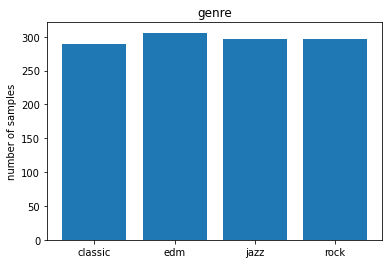

In [10]:
# get all numeric features
numeric_features = data.describe().columns

# get all features
all_features = data.columns

# get all categorical features 
categorical_features = set(all_features) - set(numeric_features)

for col in categorical_features:
  sorted_list = data[col].value_counts().sort_values().sort_index() # get the feature sorted
  labels = sorted_list.index.tolist()
  values = sorted_list.tolist()

  plt.bar(labels, values)
  plt.title(col)
  plt.ylabel("number of samples")
  plt.show()

In [87]:
data.corr()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
danceability,1.000000,0.514681,-0.006836,0.560121,-0.127711,0.091855,-0.464905,-0.304741,0.066143,0.539214,0.229261,-0.173378,0.217404
energy,0.514681,1.000000,0.061513,0.896874,-0.136171,0.346509,-0.935970,-0.527064,0.294399,0.387313,0.468759,-0.284483,0.220444
key,-0.006836,0.061513,1.000000,0.030270,-0.165526,0.021349,-0.061665,0.018439,0.017604,-0.052329,0.035670,-0.037708,-0.020931
loudness,0.560121,0.896874,0.030270,1.000000,-0.147303,0.266613,-0.818843,-0.617479,0.284850,0.444229,0.440414,-0.261007,0.227662
mode,-0.127711,-0.136171,-0.165526,-0.147303,1.000000,-0.043132,0.103894,0.098989,-0.053430,-0.035396,-0.086894,0.043454,-0.004355
speechiness,0.091855,0.346509,0.021349,0.266613,-0.043132,1.000000,-0.310027,-0.176291,0.116332,-0.042633,0.220313,-0.150182,0.061979
acousticness,-0.464905,-0.935970,-0.061665,-0.818843,0.103894,-0.310027,1.000000,0.516012,-0.254578,-0.319796,-0.450782,0.295711,-0.196295
instrumentalness,-0.304741,-0.527064,0.018439,-0.617479,0.098989,-0.176291,0.516012,1.000000,-0.181836,-0.412398,-0.285544,0.306887,-0.179013
liveness,0.066143,0.294399,0.017604,0.284850,-0.053430,0.116332,-0.254578,-0.181836,1.000000,0.105059,0.130894,-0.131239,0.070104
valence,0.539214,0.387313,-0.052329,0.444229,-0.035396,-0.042633,-0.319796,-0.412398,0.105059,1.000000,0.173293,-0.141407,0.202660


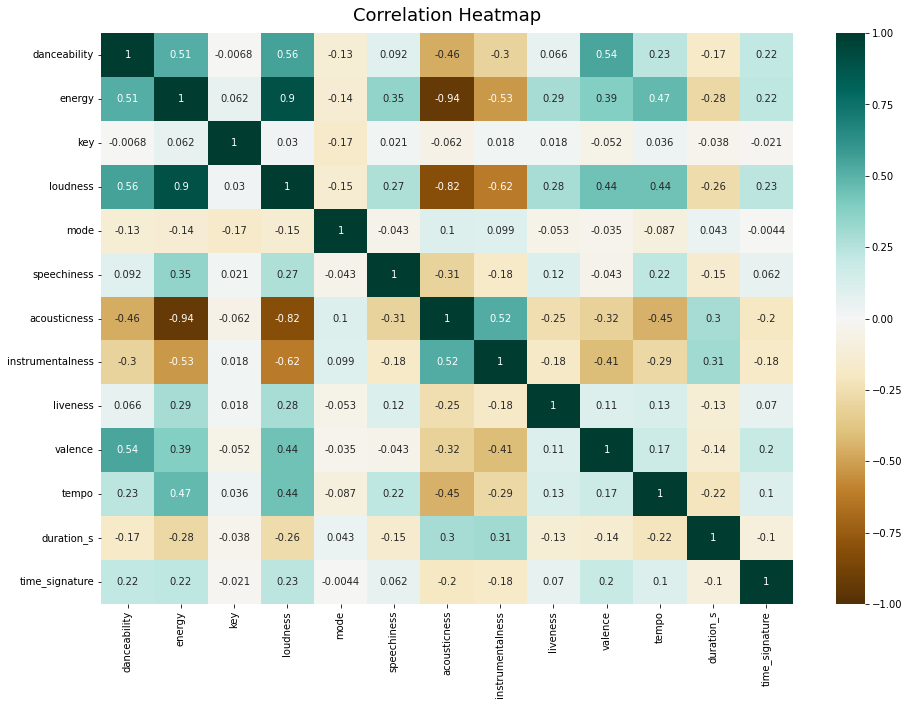

In [126]:
fig = plt.figure()
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

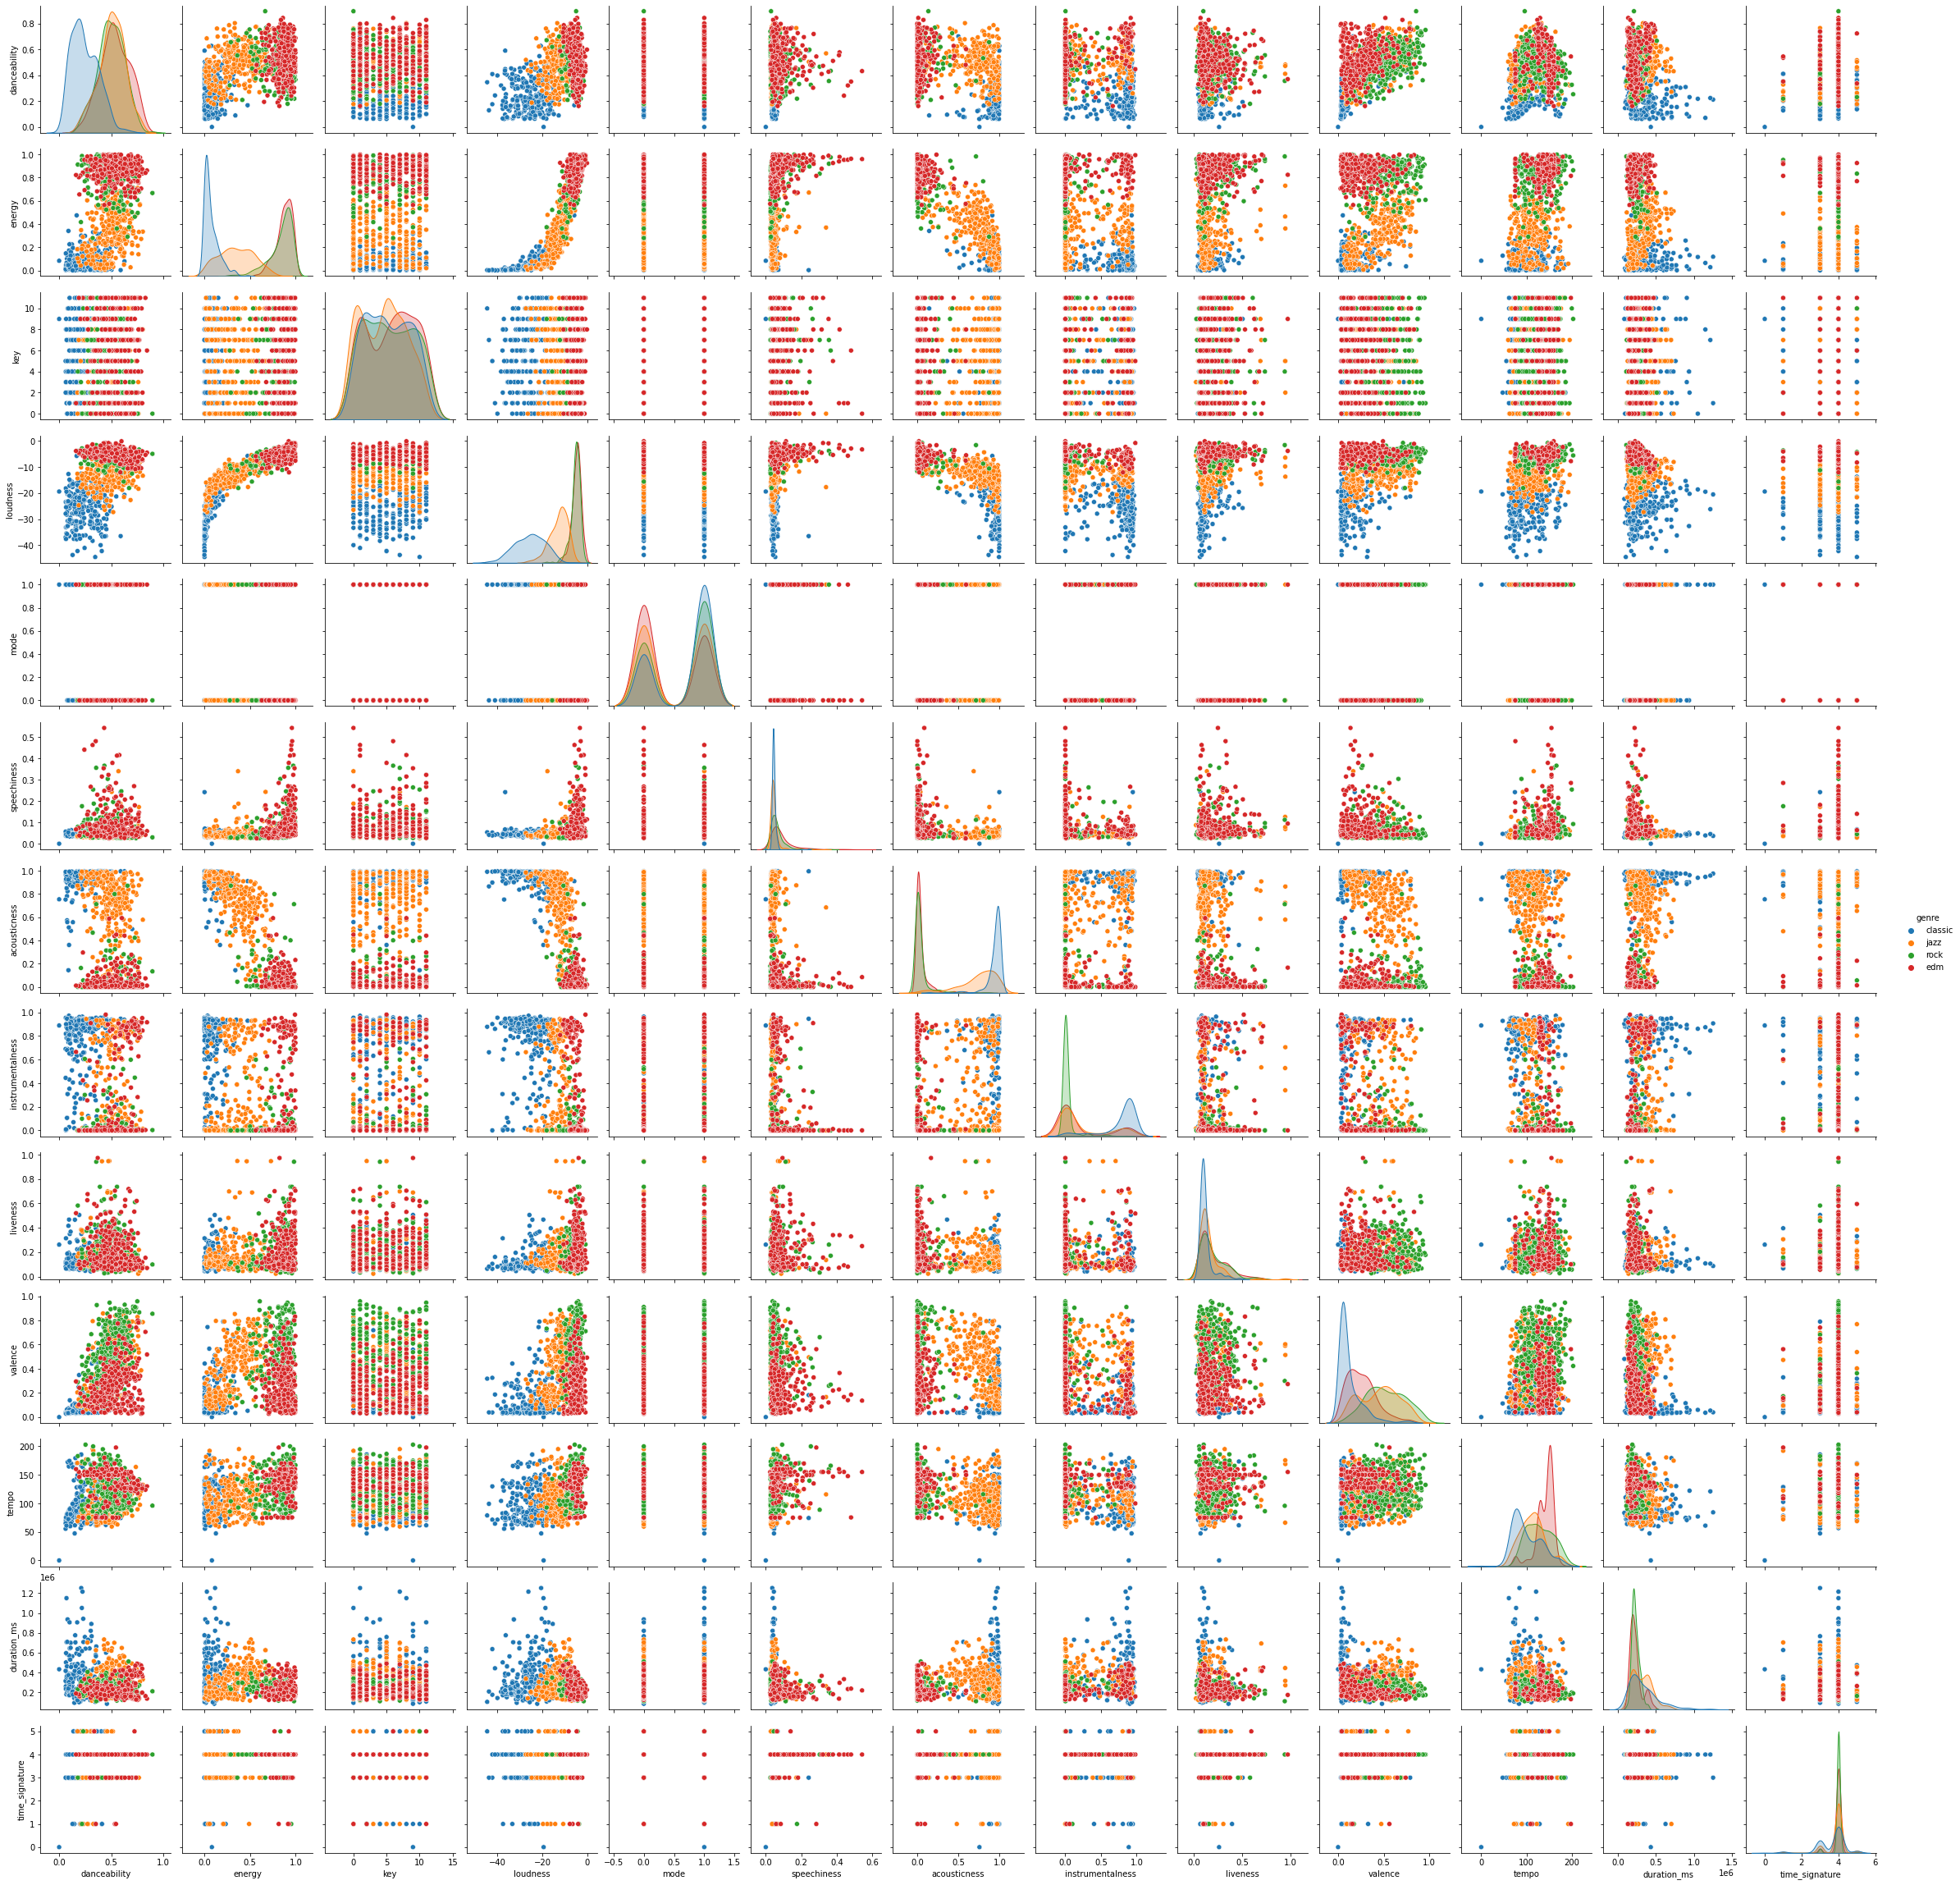

In [11]:
sns.pairplot(data=data, hue="genre")

## Preprocessing

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
0,0.1930,0.11600,9,-25.718,1,0.0608,0.98600,0.918000,0.5050,0.0836,143.301,242.467,3
1,0.3210,0.00611,4,-38.341,0,0.0362,0.99500,0.908000,0.0900,0.0693,104.311,205.493,4
2,0.4480,0.00520,4,-36.512,1,0.0564,0.99500,0.880000,0.0698,0.0398,62.171,369.027,4
3,0.4250,0.03630,1,-21.629,0,0.0686,0.99100,0.001090,0.2500,0.7450,78.991,143.777,4
4,0.0748,0.04420,0,-19.183,1,0.0426,0.95700,0.940000,0.1160,0.0369,79.092,348.907,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,0.7610,0.91700,8,-4.083,0,0.1390,0.00959,0.008480,0.0781,0.7820,131.955,151.368,4
1186,0.4360,0.70900,10,-7.185,0,0.1030,0.02290,0.005670,0.0768,0.2830,127.508,171.797,4
1187,0.7390,0.87000,2,-4.300,1,0.0396,0.01350,0.000072,0.0760,0.7410,125.022,126.720,3
1188,0.6310,0.91700,1,-3.301,0,0.2070,0.01370,0.000023,0.1000,0.1950,140.008,158.250,4


## Model Selection

In [138]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X = data.iloc[:,:13]
y = data.genre

print(cross_val_score(RandomForestClassifier(n_estimators=1000), X, y, cv=10))

[0.88983051 0.8974359  0.8974359  0.91452991 0.94871795 0.8974359
 0.94017094 0.94871795 0.90598291 0.8974359 ]


In [143]:
from sklearn.model_selection import GridSearchCV

paramGrid =  {
            'max_depth': [4,10,20,40],
            'n_estimators': [100,500,1000]
           }

id_search = GridSearchCV(
            estimator = RandomForestClassifier(), 
            param_grid = paramGrid, 
            cv = 5, 
            n_jobs = -1, 
            verbose = 1
        )

id_search.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 10, 20, 40],
                         'n_estimators': [100, 500, 1000]},
             verbose=1)

In [145]:
id_search.best_score_

0.8898527004909983